In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pypsa
import cartopy.crs as ccrs

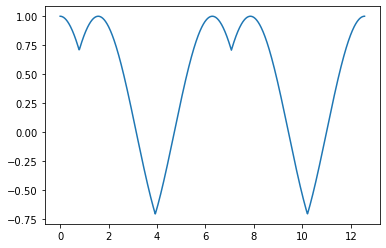

In [115]:
space = np.linspace(0, 4*np.pi, 1000)
a = np.sin(space)
b = np.cos(space)
plt.plot(space, np.maximum(a, b))

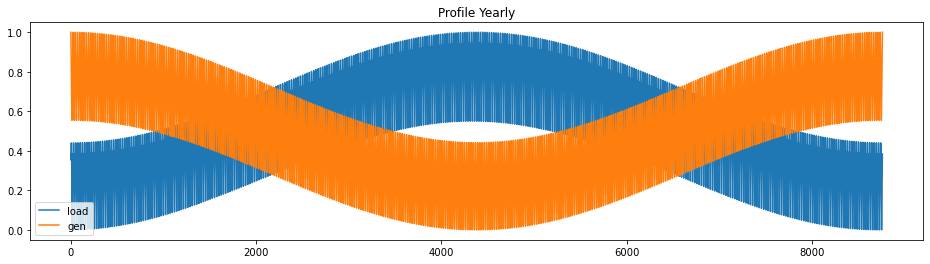

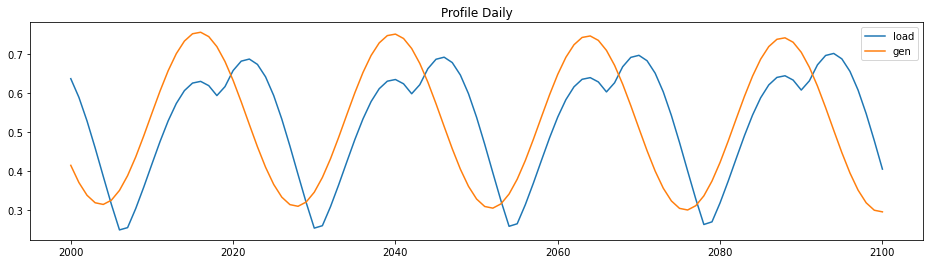

In [146]:
n = 365 * 24

load = np.array((0.3 + 
            np.maximum(0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)), 
            0.5 * np.sin(np.linspace(0, 2*365*np.pi, n)))) +
            (- 0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5))
            
load = load - min(load)
load = load / max(load)
load = pd.Series(load)

generation = np.array((0.3 + 
            0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)) + 
            (0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5)))

generation = generation - min(generation)
generation = generation / max(generation)
generation = pd.Series(generation)
        

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
load.plot(ax=ax, label='load')
generation.plot(ax=ax, label='gen')
ax.legend()
ax.set_title('Profile Yearly')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

load.loc[2000:2100].plot(ax=ax, label='load')
generation.loc[2000:2100].plot(ax=ax, label='gen')
ax.legend()
ax.set_title('Profile Daily')
plt.show()



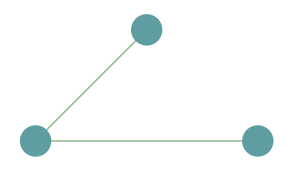

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x35041_copy
  Lower bound: 1858.9068047372562
  Upper bound: 1858.9068047372562
  Number of objectives: 1
  Number of constraints: 61321
  Number of variables: 35041
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 35041
  Number of nonzeros: 87601
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination 

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\pypsa\opf.py:1285: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



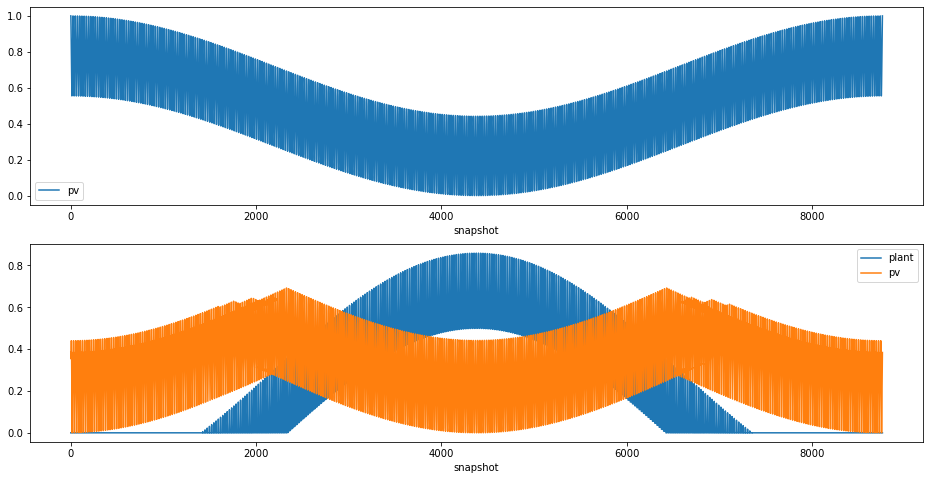

In [139]:
def build_basic_network(snapshots):

    network = pypsa.Network()
    network.snapshots = snapshots

    n = len(snapshots)

    load = np.array((0.3 + 
                np.maximum(0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)), 
                0.5 * np.sin(np.linspace(0, 2*365*np.pi, n)))) +
                (- 0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5))
                
    load = load - min(load)
    load = load / max(load)
    load = pd.Series(load)

    generation = np.array((0.3 + 
                0.4 * np.cos(np.linspace(0, 2*365*np.pi, n)) + 
                (0.5*np.cos(np.linspace(0, 2*np.pi, n)) + 0.5)))

    generation = generation - min(generation)
    generation = generation / max(generation)
    generation = pd.Series(generation)


    network.add('Bus',
                'bus_load',
                carrier='heat')
    network.add('Bus', 
                'bus_plant',
                carrier='heat')
    network.add('Bus', 
                'bus_pv',)

    network.add('Load',
                'load',
                bus='bus_load',
                p_set=load,
                carrier='heat')
    network.add('Generator',
                'plant',
                bus='bus_plant',
                p_max_pu=1.,
                p_min_pu=0.,
                marginal_cost=1.,
                p_nom=1,
                carrier='heat')
    network.add('Generator',
                'pv',
                bus='bus_pv',
                p_max_pu=generation,
                marginal_cost=0.,
                p_nom=1.)

    network.add('Link',
                'pv2load',
                bus0='bus_pv',
                bus1='bus_load',
                efficiency=1.,
                p_nom=1. 
                )
    network.add('Link',
                'plant2load',
                bus0='bus_plant',
                bus1='bus_load',
                carrier='heat',
                efficiency=1.,
                p_nom=1.)

    return network

snapshots = pd.Series(range(24*365))
network = build_basic_network(snapshots)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection":ccrs.PlateCarree()})
network.plot(ax=ax)
plt.show()

network.lopf(snapshots, solver_name='gurobi')#, pyomo=False)

fig, ax = plt.subplots(2, 1, figsize=(16, 8))
network.generators_t.p_max_pu.plot(ax=ax[0])
network.generators_t.p.plot(ax=ax[1])
plt.show()

In [57]:
def add_mixed_stes(
                    network,
                    charged_by,
                    discharges_to,
                    stes_charge_ramp_limit_up=0.05,
                    stes_charge_ramp_limit_down=0.05,
                    stes_discharge_ramp_limit_up=0.05,
                    stes_discharge_ramp_limit_down=0.05,
                    tes_ramp_limit_up=0.4,
                    tes_ramp_limit_down=0.4,
                    ):
    '''
    Adds a simple (fully mixed) seasonal 
    thermal storage to the chosen bus.
    The storage is one main storage with large moments
    of inertia in its control and a small storage
    
    Args:
        network(pypsa.Network): to this we will add the store
        charged_by(str): name of generator that loads the store
        discharges_to(str): name of that is supplied by store

        .
        .
        .
    '''


    in_bus = network.generators.loc[charged_by]['bus']
    out_bus = network.loads.loc[discharges_to]['bus']
    
    assert network.buses.loc[in_bus]['carrier'] == network.buses.loc[out_bus]['carrier'], \
            f'Unequal carriers between buses {in_bus} and {out_bus}'

    carrier = network.buses.loc[in_bus]['carrier']

    network.add('Bus', 'bus_tes', carrier=carrier)
    network.add('Bus', 'bus_stes', carrier=carrier)

    network.add('Link', bus0=in_bus, bus1='stes', p_nom=1., efficiency=1., carrier=carrier)
    network.add('Link', bus0='stes', bus1='tes', 
                    p_nom=1., 
                    efficiency=1., 
                    carrier=carrier,
                    ramp_limit_up=stes_discharge_ramp_limit_up,
                    ramp_limit_up=stes_discharge_ramp_limit_down,
                    )

    network.add('Link', bus0='tes', bus1=out_bus, p_nom=1., efficiency=1., carrier=carrier)

    # add stes
    network.add('Store', 'stes', bus='bus_stes', carrier='heat', )




    return network

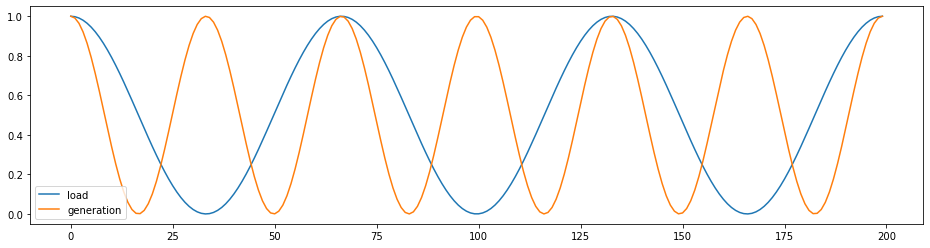

INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x801
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 1401
  Number of variables: 801
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 801
  Number of nonzeros: 2001
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (su

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\pypsa\opf.py:1285: FutureWarning:

Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().



(<SolverStatus.ok: 'ok'>, <TerminationCondition.optimal: 'optimal'>)

In [58]:
snapshots = pd.Series(range(200))

network = build_basic_network(snapshots)
network.lopf(snapshots, solver_name='gurobi')#, pyomo=False)



# network = add_mixed_stes(network, 'gen', 'load')


In [42]:
bus = network.loads.loc['load'].bus

In [21]:
network.buses.loc[bus]

attribute
v_nom            1.0
type                
x                0.0
y                0.0
carrier         Heat
unit            None
v_mag_pu_set     1.0
v_mag_pu_min     0.0
v_mag_pu_max     inf
control           PQ
sub_network         
Name: bus_load, dtype: object